In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week,label="prediction")
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

In [10]:
def guess(w,x_week,y_case):
    def season(w,x_week):
        pi = np.math.pi
        coeff = pi/52. # only 1 peak per year
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = (np.math.cos(inside))**2
        score = cosine_sq + w[-3]
        return expit(score)

    def theta(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        score = np.dot(w[:-3],pad_y)
        return expit(score)
    
    return np.log(theta(w,y_case) + 1e-9) + np.log(season(w,x_week) + 1e-9) + np.log(w[-1] + 1e-9)

In [11]:
def get_alphas(LAG,train,population):
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-W_CASE):
            real_case = (train[week_no+W_CASE] + 1)
            predicted_case = np.exp(guess(w,week_no,train[week_no:week_no+LAG]))
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
#         print ret
        return ret

    pi = np.math.pi
    pop_starter = population #np.log(population)
    seasonality_starters = [0,35] #[1500.,(pi/50),(20*pi / 52.)] # [amplitude,constant,period,phase]
#     np.random.seed(7)
#     arr = 0.15 * np.random.random_sample(W_CASE)
#     print arr
#     arr = np.array([0.]*W_CASE) #  betas
    arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 31 betas
    arr = np.append(arr,pop_starter) # 32 betas
#     return
    w = minimize(cost,arr)
    return w


In [12]:
# cr_w = get_alphas(10,cr_dengues_train)
cm_w = get_alphas(26,cm_dengues_train,900.)
# all_w = get_alphas(26,all_dengues_train,8000.)

In [9]:
cm_w

      fun: inf
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 

## see between different starting points

In [64]:
# all_w_8000 = get_alphas(26,all_dengues_train,8000.)
# all_w_3000 = get_alphas(26,all_dengues_train,3000.)
# all_w_10000 = get_alphas(26,all_dengues_train,10000.)

In [67]:
# print all_w_8000.x
# print all_w_3000.x
# print all_w_10000.x

In [25]:
cm_w
# all_w

      fun: 16851.6463076611
 hess_inv: array([[  9.99971921e-01,  -5.89918116e-04,  -5.78764662e-04,
         -5.90862036e-04,  -6.20865374e-04,  -6.56358500e-04,
         -6.95808789e-04,  -7.49674928e-04,  -8.17913622e-04,
         -8.89598029e-04,  -9.47849835e-04,  -1.01000502e-03,
         -1.05169223e-03,  -1.09787455e-03,  -1.16163540e-03,
         -1.20024147e-03,  -1.23061698e-03,  -1.25417967e-03,
         -1.26483569e-03,  -1.26559898e-03,  -1.25977646e-03,
         -1.22871136e-03,  -1.21294606e-03,  -1.19520716e-03,
         -1.20530589e-03,  -1.20799852e-03,  -1.22541865e-03,
         -4.66135406e-05,  -6.30226300e-07,  -4.66135406e-05],
       [ -5.89918116e-04,   9.87606302e-01,  -1.21593726e-02,
         -1.24135286e-02,  -1.30438742e-02,  -1.37895558e-02,
         -1.46183741e-02,  -1.57500577e-02,  -1.71836969e-02,
         -1.86897277e-02,  -1.99135506e-02,  -2.12193803e-02,
         -2.20951944e-02,  -2.30654473e-02,  -2.44050106e-02,
         -2.52160926e-02,  -2.

In [15]:
# starter_ws_df = pd.DataFrame(cm_w.x,columns=['starter_ws'])
# starter_ws_df.to_csv('starter_ws.csv')

In [85]:
# nweek_to_predict = [1,2,4,8,12]

def plot_prediction(LAG,real,ws,nweek_to_predict=[1,2,4,8,12]):

    NWEEKS = LAG
    def n_week_ahead(array_x,weeks_ahead):

        theta = 0
        arr = np.array(array_x)
        for week_no in range(weeks_ahead):
            theta = np.exp(guess(ws,week_no,arr))
            arr = np.append(arr[1:],theta)
        return theta

    for i in nweek_to_predict:
        N = NWEEKS + (i - 1)
        predictions = []
        for j in range(len(real)-N):
            initial_arr = real[j:j+NWEEKS]
            predictions.append(n_week_ahead(initial_arr,i))
#         return predictions

        title = 'Dengue Prediction %d lags: %d weeks ahead'%(NWEEKS,i)
        make_line(NWEEKS+i,real,predictions,title,"# week starting 2011","cases")

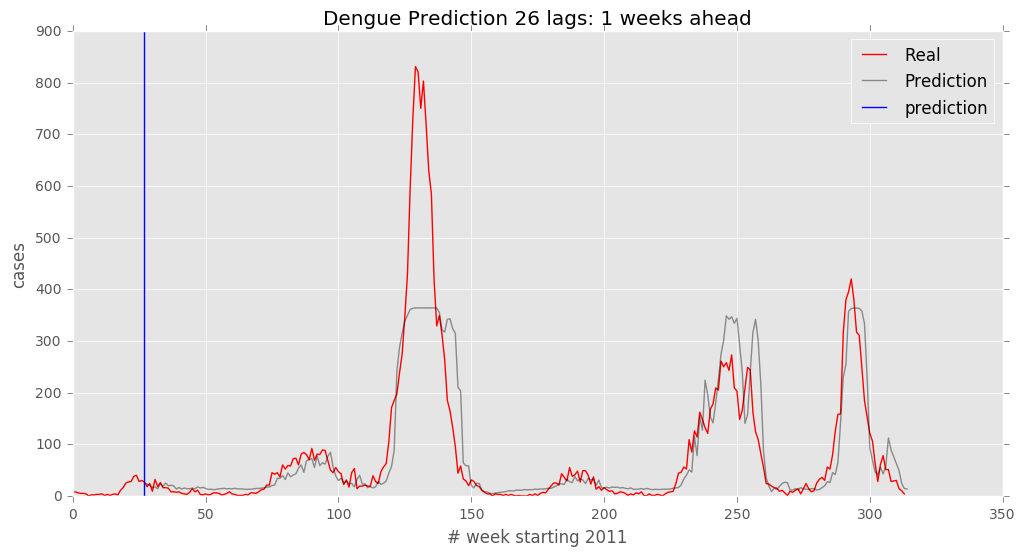

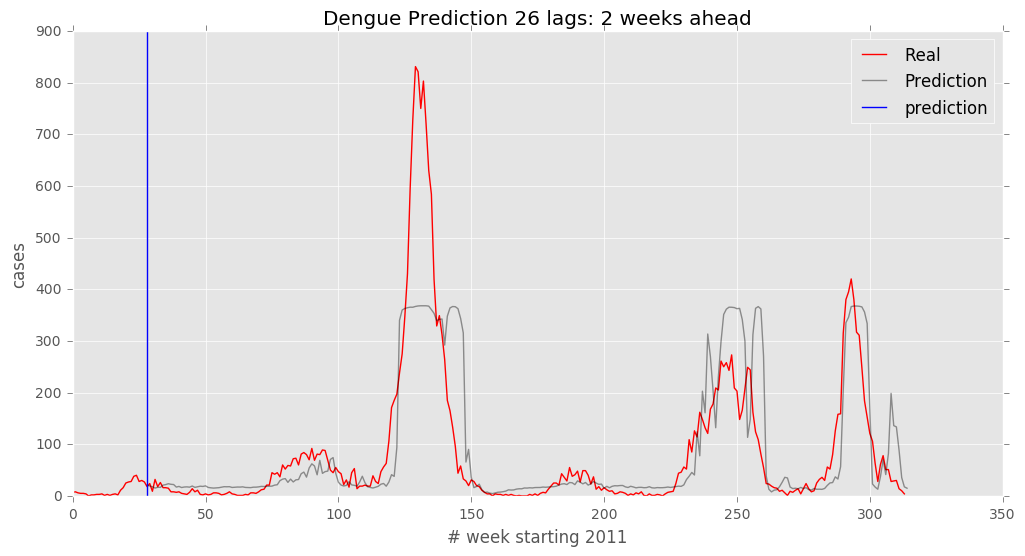

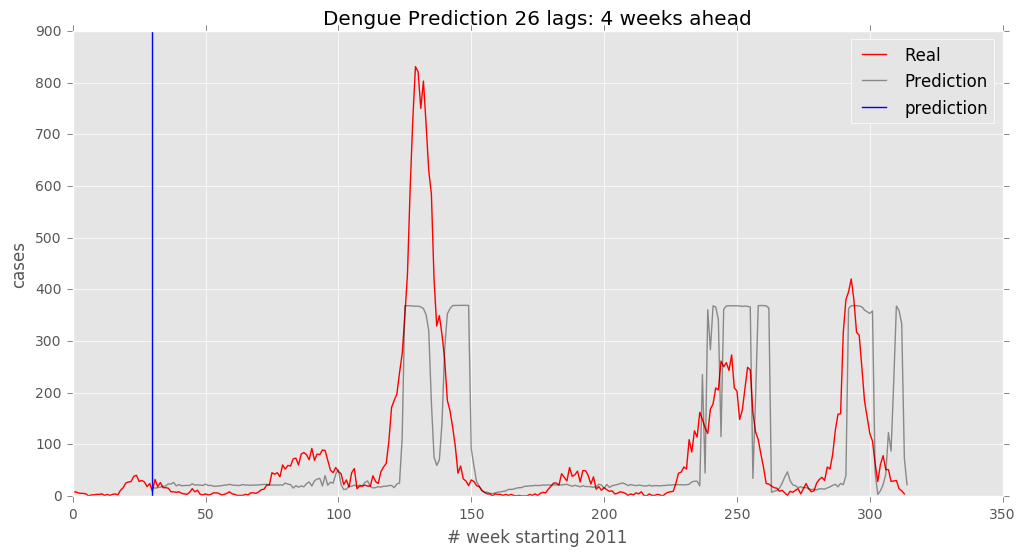

In [84]:
arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'])
plot_prediction(26,cm_dengues_test,cm_w.x,[1,2,4])
# plot_prediction(26,all_dengues_test,all_w,[1,2])

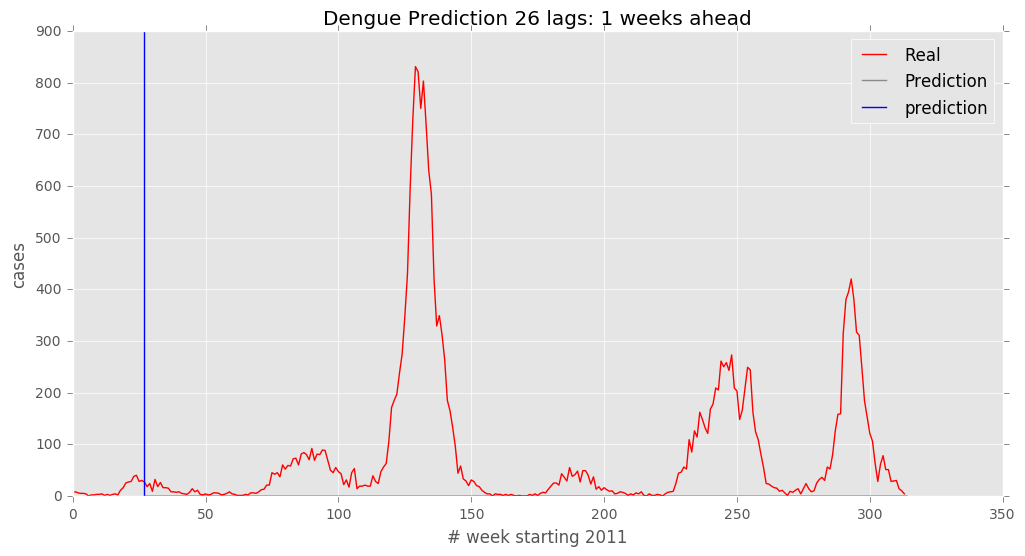

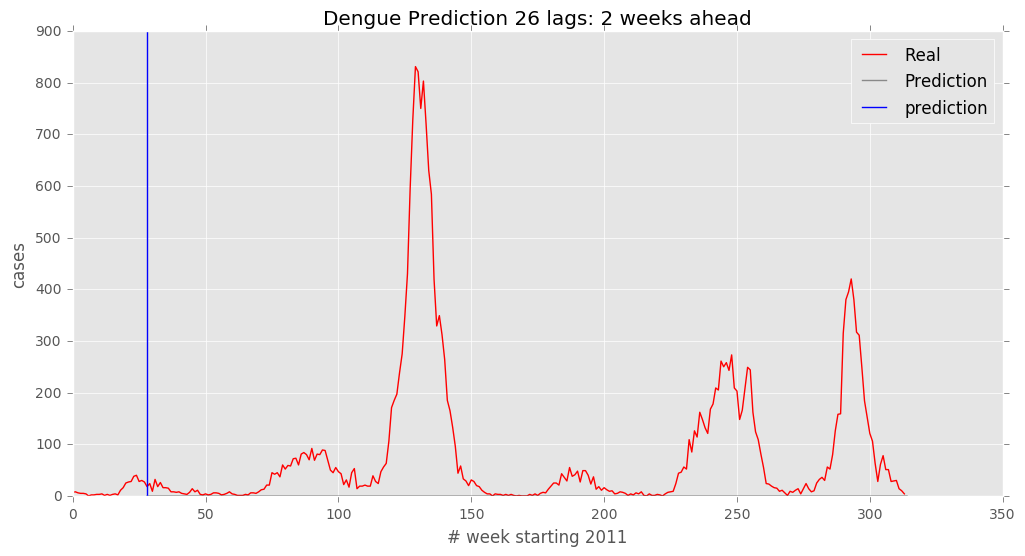

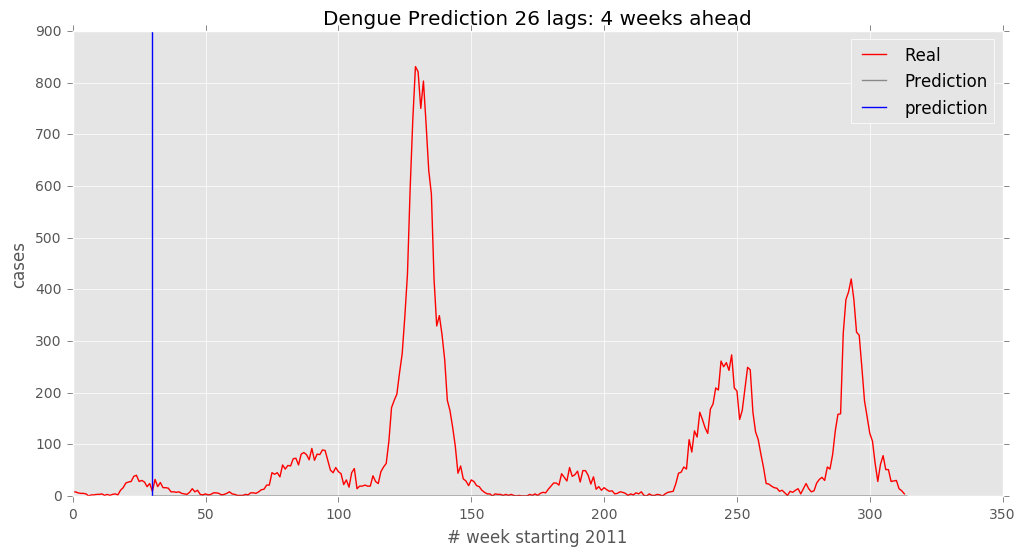

In [86]:
# ws = np.array(pd.read_csv('starter_ws.csv')['starter_ws'])
# arr = np.zeros(30)
# arr[-1] = ws[-1]
# arr[-3:-1] = [-1.08606678e+01,   5.41471278e+01]
# arr[:-3] = ws[:-1]
plot_prediction(26,cm_dengues_test,arr,[1,2,4])

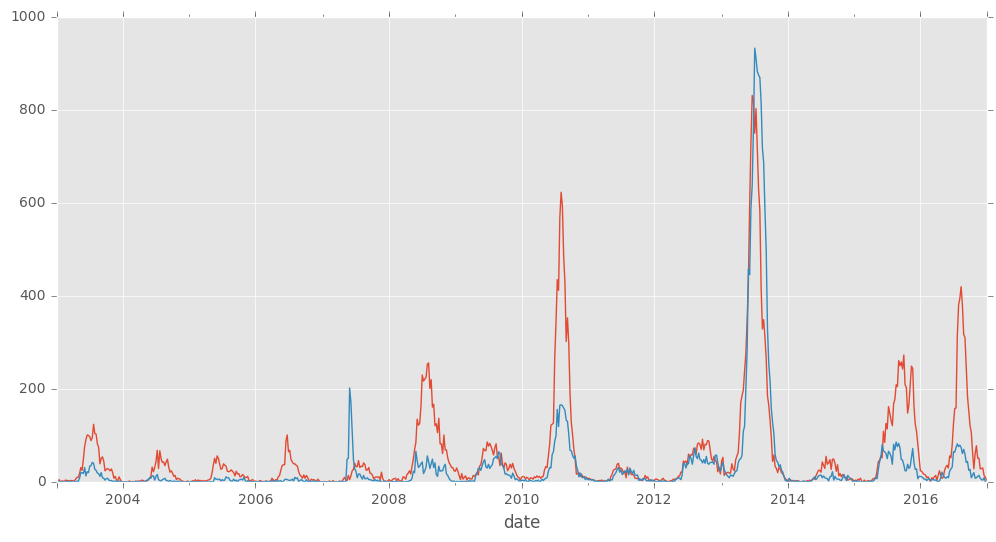

In [84]:
plt.figure(figsize=(12,6))
cm_dengues_df.cases.plot()
cr_dengues_df.cases.plot()

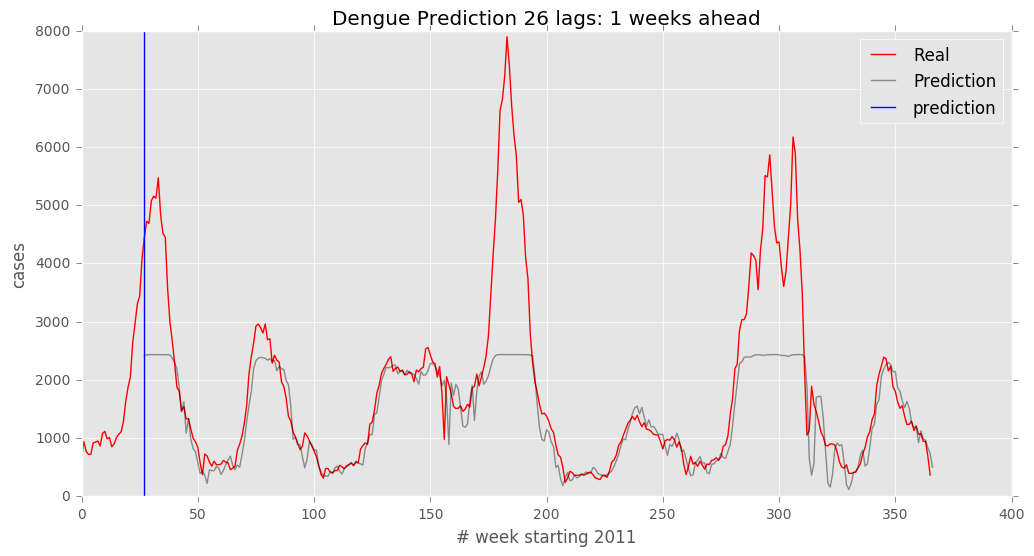

In [39]:
plot_prediction(26,all_dengues_test,all_w_10000,[1])

In [ ]:
def get_alphas(lag,train):
    
    BETAS_SET = lag + 1
    ALL_WS = BETAS_SET + 1
    
    def guess(w,x):
        def theta(w,x):
            pad_x = np.concatenate(([1],np.array(x)))
            score = np.dot(w[:-1],pad_x)
            return expit(score)

        return np.log(theta(w,x)+ 1e-5) + w[-1] 
    
    def cost(w):
        ret = 0
        for i in range(len(train)-ALL_WS):
            real_case = np.log(train[i+ALL_WS])
            predicted_case = guess(w,train[i:i+lag])
            ret += (real_case - predicted_case)**2
#         print ret/float(len(train))
        return ret/float(len(train))
    
    starter = np.log(3000.)#np.log(7500.)
    arr = np.array([0.]*BETAS_SET)
    arr = np.append(arr,starter)
    w = minimize(cost,arr)
    return w

In [45]:
def guess(w,x_week,y_case):
#     def season(w,x_week):
#         pi = np.math.pi
#         coeff = pi/52.
#         inside = (coeff*x_week) - (coeff*w[-2])
#         cosine_sq = np.math.cos(inside)**2
#         return cosine_sq + w[-3]

    def theta(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        score = np.dot(w[:-1],pad_y)
        return expit(score)
    
    return np.log(theta(w,y_case) + 1e-5) + w[-1]#season(w,x_week) + w[-1]

def get_alphas_old(LAG,train,population):
    W_CASE = LAG + 1
#     W_POP = 1
#     W_SEASON = 4
#     BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas
    
    def cost(w):
        ret = 0
        for i in range(len(train)-W_CASE):
            real_case = np.log(train[i+W_CASE])
            predicted_case = guess(w,i,train[i:i+LAG])
            ret += (real_case - predicted_case)**2
        return ret/float(len(train))

#     pi = np.math.pi
    pop_starter = np.log(population)
#     seasonality_starters = [0,0,30] #[1500.,(pi/50),(20*pi / 52.)] # [amplitude,constant,period,phase]
#     np.random.seed(7)
#     arr = 0.15 * np.random.random_sample(W_CASE)
#     print arr
    arr = np.array([0.]*W_CASE) #  betas
#     arr = np.append(arr,seasonality_starters) # 31 betas
    arr = np.append(arr,pop_starter) # 32 betas
#     return
    w = minimize(cost,arr)
    return w


In [46]:
all_w_old = get_alphas_old(52,all_dengues_train,8000.)

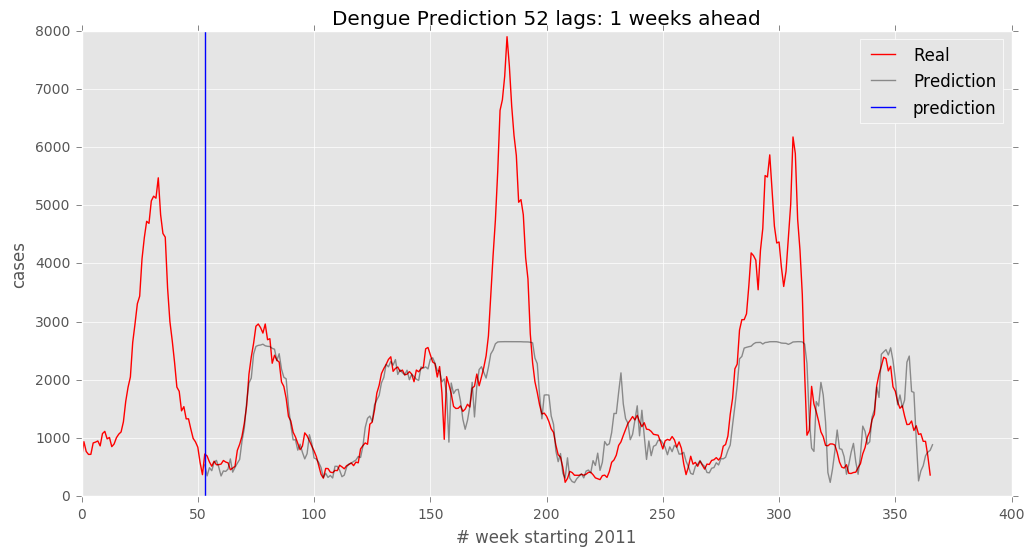

In [48]:
plot_prediction(52,all_dengues_test,all_w_old,[1])

In [256]:
tr = cm_dengues_test
nn = 11
lg = 10

def cost(w):
        ret = 0
        for week_no in range(len(tr)-nn):
            real_case = np.log(tr[week_no+nn] + 1) #np.log(train[week_no+W_CASE] + 1)
            print 'real_case',real_case
            predicted_case = guess(w,week_no,tr[week_no:week_no+lg])
            print "case",tr[week_no:week_no+lg]
            print 'pred_case',predicted_case
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            print 'sigma_sq', sigma_sq
#             ret += ((real_case - predicted_case)**2)/float(sigma_sq)
            ret += (real_case - predicted_case)**2
#             print 'ret', ret
        print ret/float(len(tr))
        return ret/float(len(tr))

ls_ = 2 * np.random.random_sample(11) - 1
ls_ = np.append(ls_,np.log(600.))
cost(ls_)

real_case 2.30258509299
case date
2010-01-03    10
2010-01-10    12
2010-01-17    11
2010-01-24     7
2010-01-31    10
2010-02-07     8
2010-02-14     5
2010-02-21     9
2010-02-28     8
2010-03-07     6
Freq: W-SUN, Name: cases, dtype: int64
pred_case 5.87518662025
sigma_sq 3.30258509299
real_case 2.63905732962
case date
2010-01-10    12
2010-01-17    11
2010-01-24     7
2010-01-31    10
2010-02-07     8
2010-02-14     5
2010-02-21     9
2010-02-28     8
2010-03-07     6
2010-03-14    11
Freq: W-SUN, Name: cases, dtype: int64
pred_case 5.35131415534
sigma_sq 3.63905732962
real_case 2.3978952728
case date
2010-01-17    11
2010-01-24     7
2010-01-31    10
2010-02-07     8
2010-02-14     5
2010-02-21     9
2010-02-28     8
2010-03-07     6
2010-03-14    11
2010-03-21     9
Freq: W-SUN, Name: cases, dtype: int64
pred_case 5.92487525082
sigma_sq 3.3978952728
real_case 2.56494935746
case date
2010-01-24     7
2010-01-31    10
2010-02-07     8
2010-02-14     5
2010-02-21     9
2010-02-28   

67.098638321500118

In [198]:
tr[11]

9